# Goals
#### Problem
IMDB has the most data available by far (in terms of both the number of films for which records exist and the number of fields related to each film.)

However, the only "metric of success" given in the IMDB data is an IMDB rating which is not necessarily related to the metric of success I want to measure (return on investment.)

The Tennessee Film, Entertainment & Music Commission has data on production budget and gross revenue which can be used to calculate return on investment.

#### Solution

I will join the Tennessee Film, Entertainment & Music Commission data to the IMDB movie basics data. If I have enough records with non-null values for the IMDB rating, then I will create a scatter plot between IMDB rating and return on investment, and I will compute the correlation between these variables with NumPy.

- If the correlation is strong, then I will use IMDB rating as a metric for success, and I will utilize all of the records within the IMDB database.

- If the correlation is NOT strong, then I will use the limited data that I have from the joining the Tennessee Film, Entertainment & Music Commission data to the IMDB data, and I will use return on investment directly as the metric of success.

#### If there is time:
- I will perform the analysis that I did on the entire IMDB dataset on the subset with return on investment information, to see if I draw the same conclusions.
- I will explore the success of individual studios using the Box Office Mojo dataset (& linking the Tennessee Film, Music & Entertainment data, if this provides enough records) to look for trends that lead to a **studio's** success and not just the success of an individual film.
- I will look for a correlation between return on investment and The Movie Database popularity rating. (26,517 movies)
- I will look for a correlation between return on investment and Rotten Tomatoes reviews. (1,560 movies)

In [2]:
import pandas as pd # Pandas
import sqlite3 # Connect to db (for IMDB data)
import numpy as np # Compute correlation between IMDB rating & return on investment

In [2]:
# Connect to IMDB database
conn = sqlite3.connect('Data/im.db')

In [3]:
# Check that connection to IMDB database is working as expected
query = ''' SELECT *
            FROM sqlite_master
            ;
            '''
pd.read_sql(query, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [6]:
# Recall name of movie title column in movie_basics table
query = ''' SELECT *
            FROM movie_basics
            LIMIT 5
            ;
            '''
pd.read_sql(query, conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [54]:
# Load Tennessee Film, Entertainment & Music Commission data
tn_films = pd.read_csv('rawData/tn.movie_budgets.csv.gz', compression='gzip')
tn_films.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [119]:
tn_films['release_date'][20].split(',')[1].strip()

'2013'

In [13]:
tn_films['release_date'].map(lambda x: x.split(',')[1].strip())

0       2009
1       2011
2       2019
3       2015
4       2017
        ... 
5777    2018
5778    1999
5779    2005
5780    2015
5781    2005
Name: release_date, Length: 5782, dtype: object

In [56]:
tn_films['movie_year'] = tn_films['movie'] + ' ' + tn_films['release_date'].map(lambda x: x.split(',')[1].strip())

In [5]:
# Find records in IMDB data which correspond to movies in the TN films data
query = f'''SELECT *
            FROM movie_basics
            WHERE primary_title IN {tuple(tn_films['movie'].values)}
            ;
            '''

imdb_titles = pd.read_sql(query, conn)

In [6]:
imdb_titles.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy"
1,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy"
2,tt0326592,The Overnight,The Overnight,2010,88.0,None
3,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance"
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama"


In [18]:
imdb_titles['movie_year'] = imdb_titles['primary_title'] + ' ' + imdb_titles['start_year'].map(lambda x: str(x))

In [7]:
len(imdb_titles)

3606

In [8]:
type(imdb_titles['start_year'][20])

numpy.int64

In [11]:
# Isolate titles of movies in both IMDB database and TN films csv
imdb_titles_only = list(imdb_titles['primary_title'].values)

In [10]:
imdb_titles.loc[20].movie_id

'tt0443272'

# Start here
This is where I stopped on Tuesday, 7/5/22. I had a "working" for loop, but it was only checking that the titles matched, without checking that the release date year and start year matched. I accidentally deleted the "working" for loop. =( So what I have left is the shell of it, edited to work via index instead of title.

I might need SQL to do this, because it is taking a *LONG* time as is!

In [30]:
imdb_ids_for_tn_films = []

for movie in tn_films['movie_year']:
    for title in imdb_titles['movie_year']:
        if movie == title:
            imdb_id = imdb_titles.loc[imdb_titles['movie_year'] == title]['movie_id'].values[0]
            break
        else:
            imdb_id = None
    imdb_ids_for_tn_films.append(imdb_id)

imdb_ids_for_tn_films

[None,
 'tt1298650',
 'tt6565702',
 'tt2395427',
 None,
 None,
 'tt4154756',
 None,
 'tt0974015',
 'tt2379713',
 'tt1345836',
 'tt3778644',
 'tt1210819',
 'tt0401729',
 'tt0398286',
 None,
 'tt3498820',
 'tt2975590',
 'tt0903624',
 None,
 'tt1170358',
 'tt2310332',
 'tt4630562',
 None,
 'tt1790809',
 None,
 'tt0848228',
 None,
 'tt0770828',
 None,
 'tt0948470',
 'tt1440129',
 'tt3371366',
 'tt0369610',
 'tt1409024',
 None,
 'tt2109248',
 None,
 'tt0955308',
 None,
 None,
 'tt1825683',
 None,
 'tt3606756',
 'tt3748528',
 'tt2277860',
 'tt0435761',
 'tt1300854',
 None,
 None,
 'tt1014759',
 'tt1074638',
 'tt1453405',
 'tt1623205',
 'tt1877832',
 'tt1872181',
 'tt1216475',
 None,
 None,
 'tt4123430',
 None,
 'tt1133985',
 None,
 'tt1399103',
 'tt2345759',
 'tt1351685',
 'tt2820852',
 'tt1408101',
 'tt0816711',
 'tt1343092',
 None,
 'tt1663662',
 'tt1979388',
 None,
 None,
 None,
 'tt1217209',
 'tt3731562',
 'tt2660888',
 'tt1856101',
 'tt6139732',
 'tt3501632',
 None,
 'tt1587310',
 'tt31

In [31]:
len(imdb_ids_for_tn_films)

5782

In [32]:
len(tn_films)

5782

In [33]:
imdb_ids_for_tn_films.count(None)

4298

In [34]:
5782 - 4298

1484

In [35]:
# Make a new column in TN films for movie_id key to link to movie_basics table in IMDB database
tn_films['imdb_id'] = imdb_ids_for_tn_films

In [36]:
# make new df, drop records from TN films which have no imdb_id
tn_imdb_combined = tn_films.dropna(subset=['imdb_id'])

In [37]:
tn_imdb_combined.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,imdb_id
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,tt1298650
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",Dark Phoenix 2019,tt6565702
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron 2015,tt2395427
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War 2018,tt4154756
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League 2017,tt0974015


In [56]:
# grab movies from imdb db movie_basics table which correspond to records in TN films
query = f''' SELECT *
            FROM movie_basics
            JOIN movie_ratings
            USING(movie_id)
            WHERE movie_id IN {tuple(tn_imdb_combined['imdb_id'].values)}
            ;
            '''
imdb_selected = pd.read_sql(query, conn)

In [39]:
# set up to use pandasql to join tables
from pandasql import sqldf

psdf = lambda x: sqldf(x, globals())

In [57]:
query = ''' SELECT *
            FROM tn_imdb_combined as t
            JOIN imdb_selected as i
            ON i.movie_id = t.imdb_id
            ;
            '''

tn_films_w_imdb = psdf(query)

In [58]:
# Let's make some histograms to see if the sample we ended up with (434) is similar in distribution to the sample we started
# with (5782)

import matplotlib as mp
import matplotlib.pyplot as plt

#### Converting Money Columns to Float Type

In [42]:
tn_films['production_budget'].describe()

count            5782
unique            509
top       $20,000,000
freq              231
Name: production_budget, dtype: object

In [72]:
def to_float(value):
# This custom function returns the value if already a float, otherwise, treats it as a string, removes 1 comma & converts to
# a float.
    if type(value) == float:
        return value
    else:
        value = value.replace(',', '')
        value = value.replace('$', '')
        value = value.strip()
        return float(value)

In [73]:
tn_films.production_budget = tn_films.production_budget.map(to_float)

In [74]:
tn_films.production_budget.describe()

count    5.782000e+03
mean     3.158776e+07
std      4.181208e+07
min      1.100000e+03
25%      5.000000e+06
50%      1.700000e+07
75%      4.000000e+07
max      4.250000e+08
Name: production_budget, dtype: float64

In [75]:
tn_films_w_imdb['production_budget'] = tn_films_w_imdb.production_budget.map(to_float)

NameError: name 'tn_films_w_imdb' is not defined

In [60]:
tn_films_w_imdb['production_budget'].describe()

count    1.461000e+03
mean     4.509631e+07
std      5.644700e+07
min      1.500000e+04
25%      8.000000e+06
50%      2.400000e+07
75%      5.750000e+07
max      4.106000e+08
Name: production_budget, dtype: float64

In [64]:
tn_films_w_imdb['worldwide_gross'] = tn_films_w_imdb.worldwide_gross.map(to_float)

In [65]:
tn_films_w_imdb.worldwide_gross.describe()

count    1.461000e+03
mean     1.432564e+08
std      2.352418e+08
min      0.000000e+00
25%      8.514325e+06
50%      5.410422e+07
75%      1.625028e+08
max      2.048134e+09
Name: worldwide_gross, dtype: float64

In [66]:
tn_films_w_imdb['domestic_gross'] = tn_films_w_imdb.domestic_gross.map(to_float)

In [67]:
tn_films_w_imdb.domestic_gross.describe()

count    1.461000e+03
mean     5.716461e+07
std      8.529839e+07
min      0.000000e+00
25%      3.322127e+06
50%      2.884224e+07
75%      6.917907e+07
max      7.000596e+08
Name: domestic_gross, dtype: float64

#### End: Converting Money Columns to Float Type

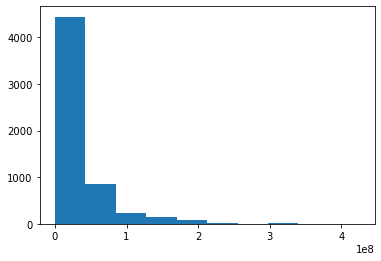

In [50]:
# distribution of production budget in original TN films dataset

fig, ax = plt.subplots()

ax.hist(tn_films['production_budget']);

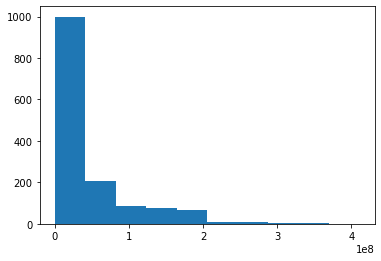

In [61]:
# distribution of production budget in TN films with IMDB data

fig, ax = plt.subplots()

ax.hist(tn_films_w_imdb['production_budget']);

Excellent! The subset of films for which we have both IMDB data **and** production budget / gross revenue data are similarly distributed, in terms of production budget, as the larger original TN films data set.

In [62]:
# check that I have imdb rating column now
tn_films_w_imdb.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,imdb_id,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,tt1298650,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",6.6,447624
1,3,"Jun 7, 2019",Dark Phoenix,350000000.0,"$42,762,350","$149,762,350",Dark Phoenix 2019,tt6565702,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451


In [69]:
# make a new column for return on investment, roi
tn_films_w_imdb['roi'] = (tn_films_w_imdb['worldwide_gross'] - tn_films_w_imdb['production_budget']) / tn_films_w_imdb['production_budget']

In [71]:
# check that new column "worked"
tn_films_w_imdb.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,imdb_id,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,roi
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides 2011,tt1298650,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",6.6,447624,1.546673
1,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix 2019,tt6565702,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451,-0.572108


In [72]:
# curious about distribution of roi
tn_films_w_imdb.roi.describe()

count    1461.000000
mean        2.703887
std        12.171599
min        -1.000000
25%        -0.253786
50%         1.135069
75%         3.011785
max       415.564740
Name: roi, dtype: float64

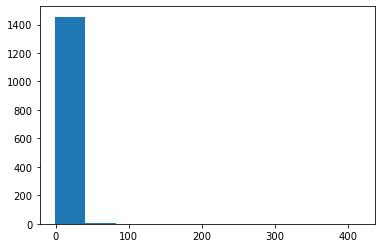

In [73]:
# I was curious about the distribution of roi (like what is an exceptional roi in this dataset); need to come back &
# customize this histogram to illustrate the distribution better
fig, ax = plt.subplots()

ax.hist(tn_films_w_imdb['roi']);

#### Are imdb rating and return on investment correlated?

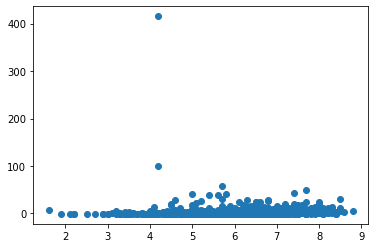

In [74]:
fig, ax = plt.subplots()

ax.scatter(tn_films_w_imdb['averagerating'], tn_films_w_imdb['roi']);

In [88]:
correlation_matrix = np.corrcoef(tn_films_w_imdb['averagerating'], tn_films_w_imdb['roi'])
corr_imdb_rating_roi = correlation_matrix[0][1]

In [89]:
corr_imdb_rating_roi

0.022642292212821154

So sad! IMDB rating and return on investment are NOT correlated.

#### Are imdb rating and worldwide gross correlated?

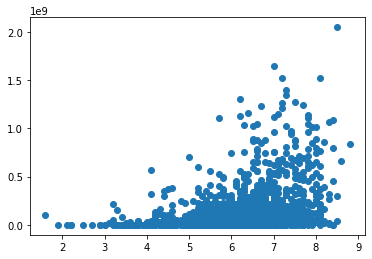

In [78]:
fig, ax = plt.subplots()

ax.scatter(tn_films_w_imdb['averagerating'], tn_films_w_imdb['worldwide_gross']);

In [84]:
correlation_matrix = np.corrcoef(tn_films_w_imdb['averagerating'], tn_films_w_imdb['worldwide_gross'])
corr_imdb_rating_wwgross = correlation_matrix[0][1]

In [85]:
corr_imdb_rating_wwgross

0.3104582676832908

Not much. But a little bit!

Just for fun, let's also check...

#### are average rating and domestic gross correlated?

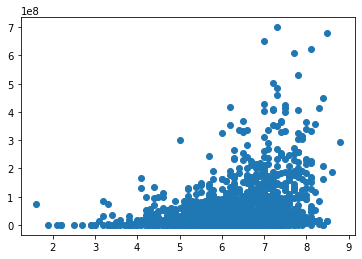

In [81]:
fig, ax = plt.subplots()

ax.scatter(tn_films_w_imdb['averagerating'], tn_films_w_imdb['domestic_gross']);

In [86]:
correlation_matrix = np.corrcoef(tn_films_w_imdb['averagerating'], tn_films_w_imdb['domestic_gross'])
corr_imdb_rating_dgross = correlation_matrix[0][1]

In [87]:
corr_imdb_rating_dgross

0.32886967161140995

### Reset

#### Problem

So maybe my idea was just bad - perhaps imdb rating and return on investment, gross revenue are NOT correlated enough to use imdb rating as a pseudo-metric for monetary success.

OR maybe I just need to control for something like number of votes. I am going to spend 5 minutes trying to do that, then accept my defeat and move on.

In [90]:
tn_films_w_imdb.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,imdb_id,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,roi
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides 2011,tt1298650,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",6.6,447624,1.546673
1,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix 2019,tt6565702,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451,-0.572108
2,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,Avengers: Age of Ultron 2015,tt2395427,tt2395427,Avengers: Age of Ultron,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594,3.243841
3,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,Avengers: Infinity War 2018,tt4154756,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",8.5,670926,5.827114
4,9,"Nov 17, 2017",Justice League,300000000.0,229024295.0,6.559452e+08,Justice League 2017,tt0974015,tt0974015,Justice League,Justice League,2017,120.0,"Action,Adventure,Fantasy",6.5,329135,1.186484


In [91]:
tn_films_w_imdb['numvotes'].describe()

count    1.461000e+03
mean     1.175619e+05
std      1.652257e+05
min      5.000000e+00
25%      1.574300e+04
50%      6.016500e+04
75%      1.448210e+05
max      1.841066e+06
Name: numvotes, dtype: float64

In [92]:
len(tn_films_w_imdb[tn_films_w_imdb['numvotes'] > 100000])

518

In [93]:
films_w_votes = tn_films_w_imdb[tn_films_w_imdb['numvotes'] > 100000]

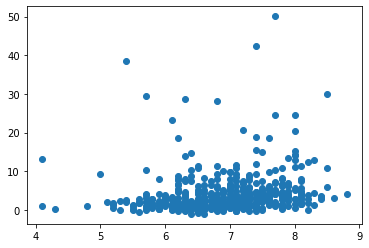

In [94]:
fig, ax = plt.subplots()

ax.scatter(films_w_votes['averagerating'], films_w_votes['roi']);

In [95]:
correlation_matrix = np.corrcoef(films_w_votes['averagerating'], films_w_votes['roi'])
correlation_matrix[0][1]

0.16165642519264026

Nope! That was only 3 minutes, but I am going to move on.

### A New Era: Using Smaller Subset of Films to Perform Analysis

In [96]:
len(tn_films_w_imdb)

1461

I have 1461 films to work with. Let's explore:

- What are the most successful genres? In terms of ROI? In terms of worldwide gross?
- Who are the most successful directors in that genre? (i.e. summing gross revenue on all films that director produced in that genre, then dividing by the sum of all production budgets) (or you can find the average ROI of all films that director produced in that genre - probably a more clear metric)
- Similarly, who are the most successful writers?

In [97]:
tn_films_w_imdb.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,imdb_id,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,roi
0,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,Pirates of the Caribbean: On Stranger Tides 2011,tt1298650,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",6.6,447624,1.546673
1,3,"Jun 7, 2019",Dark Phoenix,350000000.0,42762350.0,1.497624e+08,Dark Phoenix 2019,tt6565702,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",6.0,24451,-0.572108


To analyze success of genres, I want to look at the combos as given AND individual genres.

#### What are the most popular genre combinations? (fix x-tick labels)

''

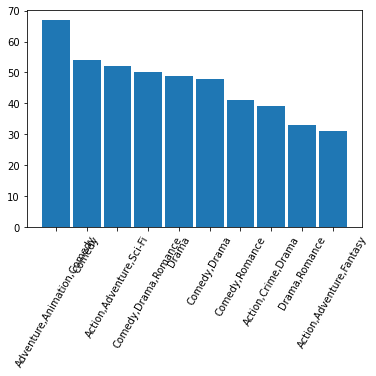

In [115]:
# What are the most popular genre combinations?
fig, ax = plt.subplots()

x_positions = np.linspace(0,1,10)

ax.bar(x=x_positions, width=0.1, height=tn_films_w_imdb['genres'].value_counts()[:10],\
       tick_label = tn_films_w_imdb['genres'].value_counts().index[:10], align='center')
plt.xticks(rotation=60)
;

# The Movie Database
### Is the movie db rating correlated to return on investment?

In [34]:
tmdb_movies = pd.read_csv('rawData/tmdb.movies.csv.gz', compression='gzip', index_col=0)

In [35]:
tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [36]:
len(tmdb_movies)

26517

In [37]:
tmdb_movies['id'].value_counts()[:997]

292086    3
463839    3
11976     3
391872    3
416572    3
         ..
273248    2
258152    2
68730     2
378017    2
353066    1
Name: id, Length: 997, dtype: int64

In [38]:
tmdb_movies[tmdb_movies['id'] == 273248]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
14194,"[80, 18, 9648, 37]",273248,en,The Hateful Eight,20.681,2015-12-25,The Hateful Eight,7.7,8065
17403,"[80, 18, 9648, 37]",273248,en,The Hateful Eight,20.681,2015-12-25,The Hateful Eight,7.7,8065


In [42]:
tmdb_movies.drop_duplicates(inplace=True)

In [43]:
len(tmdb_movies)

25497

In [44]:
tmdb_movies['movie_year'] = tmdb_movies['original_title'] + ' ' + tmdb_movies['release_date'][15][:4]

In [47]:
tmdb_movies.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,movie_year
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,Harry Potter and the Deathly Hallows: Part 1 2010
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,How to Train Your Dragon 2010
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Iron Man 2 2010
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,Toy Story 2010
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,Inception 2010


In [52]:
type(tmdb_movies.loc[tmdb_movies['movie_year'] == 'How to Train Your Dragon 2010']['id'].values[0])

numpy.int64

In [46]:
tmdb_movies.loc[tmdb_movies['movie_year'] == 'The Hateful Eight 2015']

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,movie_year


In [57]:
tmdb_ids = []

for movie in tn_films['movie_year']:
    for title in tmdb_movies['movie_year']:
        if movie == title:
            tmdb_id = tmdb_movies.loc[tmdb_movies['movie_year'] == title]['id'].values[0]
            break
        else:
            tmdb_id = None
    tmdb_ids.append(tmdb_id)

tmdb_ids

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 38757,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 20662,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 10193,
 None,
 None,
 None,
 12155,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 10138,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 10192,
 None,
 None,
 10191,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 27205,
 None,
 None,
 None,
 None

In [58]:
tmdb_ids.count(None)

5589

In [59]:
len(tmdb_ids)

5782

In [60]:
5782 - 5589

193

In [79]:
tn_films['tmdb_id'] = tmdb_ids

In [80]:
tn_films.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,tmdb_id
0,1,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,Avatar 2009,NaN
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000.0,"$241,063,875",1.045664e+09,Pirates of the Caribbean: On Stranger Tides 2011,NaN
2,3,"Jun 7, 2019",Dark Phoenix,350000000.0,"$42,762,350",1.497624e+08,Dark Phoenix 2019,NaN
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000.0,"$459,005,868",1.403014e+09,Avengers: Age of Ultron 2015,NaN
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000.0,"$620,181,382",1.316722e+09,Star Wars Ep. VIII: The Last Jedi 2017,NaN


In [81]:
tn_films_w_tmdb = tn_films.dropna(subset=['tmdb_id'])

In [82]:
tn_films_w_tmdb.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,tmdb_id
14,15,"Nov 24, 2010",Tangled,260000000.0,"$200,821,936",5.864772e+08,Tangled 2010,38757.0
38,39,"May 14, 2010",Robin Hood,210000000.0,"$105,487,148",3.224590e+08,Robin Hood 2010,20662.0
46,47,"Jun 18, 2010",Toy Story 3,200000000.0,"$415,004,880",1.068880e+09,Toy Story 3 2010,10193.0
50,51,"Mar 5, 2010",Alice in Wonderland,200000000.0,"$334,191,110",1.025491e+09,Alice in Wonderland 2010,12155.0
114,15,"May 7, 2010",Iron Man 2,170000000.0,"$312,433,331",6.211564e+08,Iron Man 2 2010,10138.0


In [83]:
len(tn_films_w_tmdb)

193

In [67]:
from pandasql import sqldf

psdf = lambda x: sqldf(x, globals())

In [84]:
query = ''' SELECT *
            FROM tn_films_w_tmdb as tn
            JOIN tmdb_movies as tmdb
            ON tn.tmdb_id = tmdb.id
            ;
            '''

tn_w_tmdb_full = psdf(query)

In [88]:
tn_w_tmdb_full.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_year,tmdb_id,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,movie_year,roi
0,15,"Nov 24, 2010",Tangled,260000000.0,"$200,821,936",5.864772e+08,Tangled 2010,38757.0,"[16, 10751]",38757,en,Tangled,21.511,2010-11-24,Tangled,7.5,6407,Tangled 2010,1.255682
1,39,"May 14, 2010",Robin Hood,210000000.0,"$105,487,148",3.224590e+08,Robin Hood 2010,20662.0,"[28, 12, 18]",20662,en,Robin Hood,15.444,2010-05-14,Robin Hood,6.3,2569,Robin Hood 2010,0.535519
2,47,"Jun 18, 2010",Toy Story 3,200000000.0,"$415,004,880",1.068880e+09,Toy Story 3 2010,10193.0,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,Toy Story 3 2010,4.344398
3,51,"Mar 5, 2010",Alice in Wonderland,200000000.0,"$334,191,110",1.025491e+09,Alice in Wonderland 2010,12155.0,"[10751, 14, 12]",12155,en,Alice in Wonderland,22.020,2010-03-05,Alice in Wonderland,6.6,8713,Alice in Wonderland 2010,4.127456
4,15,"May 7, 2010",Iron Man 2,170000000.0,"$312,433,331",6.211564e+08,Iron Man 2 2010,10138.0,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Iron Man 2 2010,2.653861


In [71]:
len(tn_w_tmdb_full)

193

In [76]:
tn_films.worldwide_gross = tn_films.worldwide_gross.map(to_float)

In [87]:
tn_w_tmdb_full['roi'] = (tn_w_tmdb_full['worldwide_gross'] - tn_w_tmdb_full['production_budget']) / tn_w_tmdb_full['production_budget']

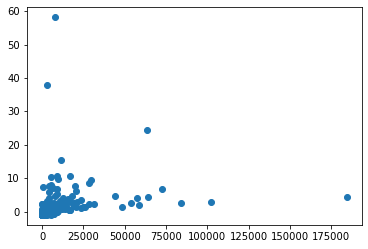

In [90]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(tn_w_tmdb_full['vote_average']*tn_w_tmdb_full['vote_count'], tn_w_tmdb_full['roi']);

# Rotten Tomatoes

In [92]:
rt_movies = pd.read_csv('rawData/rt.movie_info.tsv.gz', sep='\t', compression='gzip', index_col=0)
rt_movies.head()

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
id,,,,,,,,,,,
1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [93]:
rt_reviews = pd.read_csv('rawData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='unicode_escape')
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [95]:
query = ''' SELECT *
            FROM rt_movies
            JOIN rt_reviews
            USING(id);
            '''

rt_all = psdf(query)

Oops, Rotten Tomatoes doesn't give you the film name. xD

# Box Office Mojo

In [98]:
bom_movies = pd.read_csv('rawData/bom.movie_gross.csv.gz')

bom_movies.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [99]:
bom_movies['year'].describe()

count    3387.000000
mean     2013.958075
std         2.478141
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2018.000000
Name: year, dtype: float64

In [101]:
bom_movies['movie_year'] = bom_movies['title'] + ' ' + bom_movies['year'].map(lambda x: str(x))

In [103]:
query = ''' SELECT *
            FROM tn_films
            INNER JOIN bom_movies
            USING(movie_year)
            ;
            '''
bom_w_tn = psdf(query)

In [107]:
bom_w_tn['roi'] = (bom_w_tn['worldwide_gross'] - bom_w_tn['production_budget']) / bom_w_tn['production_budget']

In [112]:
query = ''' SELECT studio, AVG(roi) AS 'average_roi'
            FROM bom_w_tn
            GROUP BY studio
            ORDER BY AVG(roi) DESC
            LIMIT 20
            ;'''

psdf(query)

,studio,average_roi
0,WB (NL),16.495934
1,FD,11.568032
2,UTV,11.171985
3,Orch.,8.538213
4,GrtIndia,7.783430
5,BH Tilt,6.896510
6,Uni.,5.886268
7,Par.,5.856471
8,TriS,4.917258
9,MBox,4.883983
